In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn import metrics
from imblearn.over_sampling import SMOTE
from sklearn.metrics import plot_confusion_matrix

Now we will read the CSV to pandas Dataframe

In [52]:
train_file = pd.read_csv('aug_train.csv')
test_file = pd.read_csv('aug_test.csv')
print(train_file)

       enrollee_id      city  city_development_index gender  \
0             8949  city_103                   0.920   Male   
1            29725   city_40                   0.776   Male   
2            11561   city_21                   0.624    NaN   
3            33241  city_115                   0.789    NaN   
4              666  city_162                   0.767   Male   
...            ...       ...                     ...    ...   
19153         7386  city_173                   0.878   Male   
19154        31398  city_103                   0.920   Male   
19155        24576  city_103                   0.920   Male   
19156         5756   city_65                   0.802   Male   
19157        23834   city_67                   0.855    NaN   

           relevent_experience enrolled_university education_level  \
0      Has relevent experience       no_enrollment        Graduate   
1       No relevent experience       no_enrollment        Graduate   
2       No relevent experience   

### Data Analysis

<br>

In [32]:
missing_values = train_file.count().sum()
total_values = np.product(train_file.shape)
percentages = train_file.isna().sum().reset_index().rename(columns={'index': 'Column', 0:'Missing'})
percentages['Percentage'] = percentages['Missing']/train_file.shape[0]*100

print(f'Amount of total missing data in train set: {missing_values}\nRelative amount of missing data: {missing_values/total_values*100:.3f}%')
print('-'*20)
print(f'Missing data per column: \n\n', percentages)

Amount of total missing data in train set: 247479
Relative amount of missing data: 92.270%
--------------------
Missing data per column: 

                     Column  Missing  Percentage
0              enrollee_id        0    0.000000
1                     city        0    0.000000
2   city_development_index        0    0.000000
3                   gender     4508   23.530640
4      relevent_experience        0    0.000000
5      enrolled_university      386    2.014824
6          education_level      460    2.401086
7         major_discipline     2813   14.683161
8               experience       65    0.339284
9             company_size     5938   30.994885
10            company_type     6140   32.049274
11            last_new_job      423    2.207955
12          training_hours        0    0.000000
13                  target        0    0.000000


In [33]:
def plot(data, column):
    fig, ax = plt.subplots(1,2, figsize=(12,6))
    perc = percentages.query(f'Column == "{column}"')['Percentage'].values
    sns.countplot(data=data, x=column, ax=ax[0])
    ax[1].pie(train_file[column].value_counts().values, labels=train_file[column].value_counts().index, autopct='%1.1f%%')
    fig.tight_layout()
    fig.suptitle(f'Column: \'{column}\'    -    Missing data: {perc[0]:.2f}%', fontsize=30)
    fig.subplots_adjust(top=0.88)
    fig.show()

<ipython-input-33-51c9f87695a3>:9: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


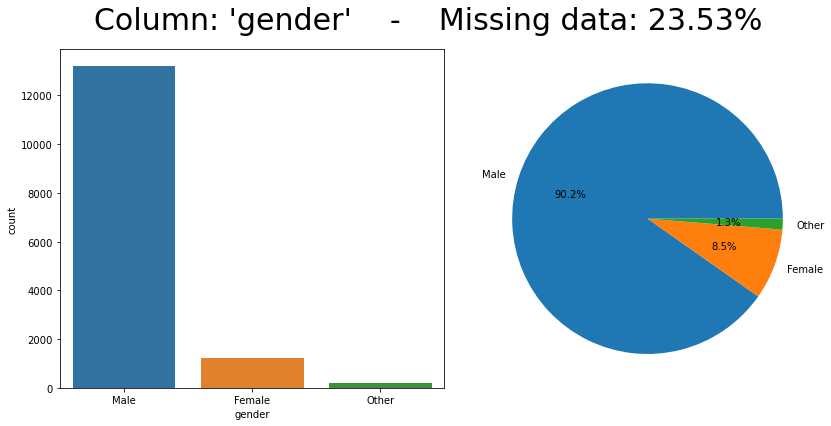

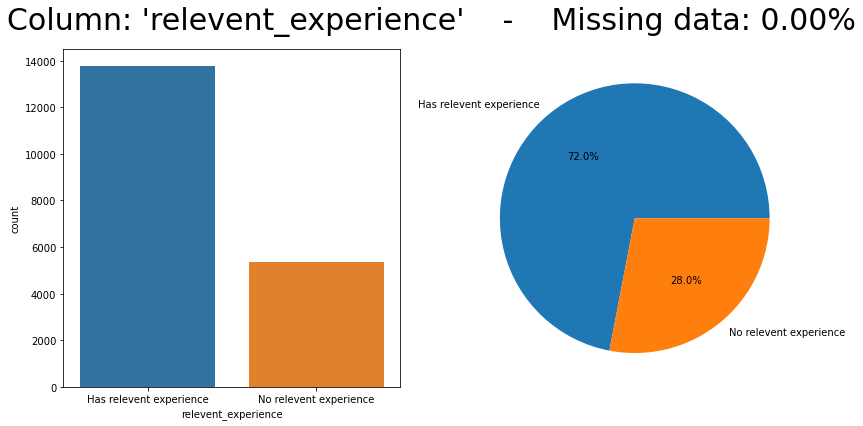

In [34]:
plot(train_file,'gender') # use one-hot-encoding
plot(train_file, 'relevent_experience') # There are no missing values, and the features can have a numerical ordering
# plot(train_file, 'enrolled_university') # Use one-hot-encoding does not have many missing values
# plot(train_file, 'education_level') # Same amount of missing data as the enrolled_university column, we can classify features in numerical ordering
# plot(train_file, 'major_discipline') # Contains alot of missing data, Data scientists from a STEM background is a more prominant value, using one-hot-encoding shouldnt create any biases
# plot(train_file, 'experience') # Balanced column counts, with few data missing so for this column we should just remove the missing values and treat the values as numeric variable
# plot(train_file, 'company_size') # Since there is alot of missing data in the column imputing will introduce alot of bias, we will drop this column completely
# plot(train_file, 'company_type') # Same as company_size column many missing values we will drop this column aswell
# plot(train_file, 'last_new_job') # We will just encode never to value 0 and >4 to 5
# plot(train_file, 'training_hours') # continuous values with no missing data

<br>

### PreProcessing 

In [35]:
train_file = train_file.drop(['company_size','company_type'],axis=1)
test_file = test_file.drop(['company_size','company_type'],axis=1)

In [36]:
print('Train NA values: \n', train_file.isnull().sum())
print('Test NA values: \n', test_file.isnull().sum())

Train NA values: 
 enrollee_id                  0
city                         0
city_development_index       0
gender                    4508
relevent_experience          0
enrolled_university        386
education_level            460
major_discipline          2813
experience                  65
last_new_job               423
training_hours               0
target                       0
dtype: int64
Test NA values: 
 enrollee_id                 0
city                        0
city_development_index      0
gender                    508
relevent_experience         0
enrolled_university        31
education_level            52
major_discipline          312
experience                  5
last_new_job               40
training_hours              0
dtype: int64


In [37]:
def impute_most_frequent(DataFrame, ColName):
    most_frequent_category= DataFrame[ColName].mode()[0]
#     Replace unknown values with most occured category
    DataFrame[ColName].fillna(most_frequent_category, inplace=True)

In [38]:
for i in train_file.select_dtypes(include = 'object').columns:
    impute_most_frequent(train_file,i)

for i in test_file.select_dtypes(include = 'object').columns:
    impute_most_frequent(test_file,i)

<br>

### LabelEncoding 

In [39]:
objList = train_file.select_dtypes(include='object').columns
print("Categorical columns: ", objList )

Categorical columns:  Index(['city', 'gender', 'relevent_experience', 'enrolled_university',
       'education_level', 'major_discipline', 'experience', 'last_new_job'],
      dtype='object')


In [40]:
le = preprocessing.LabelEncoder()
train_encoded = train_file.copy()
test_encoded = test_file.copy()
for feat in objList:
    train_encoded[feat] = le.fit_transform(train_file[feat].astype(str))
    test_encoded[feat] = le.fit_transform(test_file[feat].astype(str))

In [41]:
test_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2129 entries, 0 to 2128
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   enrollee_id             2129 non-null   int64  
 1   city                    2129 non-null   int64  
 2   city_development_index  2129 non-null   float64
 3   gender                  2129 non-null   int64  
 4   relevent_experience     2129 non-null   int64  
 5   enrolled_university     2129 non-null   int64  
 6   education_level         2129 non-null   int64  
 7   major_discipline        2129 non-null   int64  
 8   experience              2129 non-null   int64  
 9   last_new_job            2129 non-null   int64  
 10  training_hours          2129 non-null   int64  
dtypes: float64(1), int64(10)
memory usage: 183.1 KB


In [51]:
X = train_encoded.drop('target', axis=1)
Y = train_encoded.target
print(X)

       enrollee_id  city  city_development_index  gender  relevent_experience  \
0             8949     5                   0.920       1                    0   
1            29725    77                   0.776       1                    1   
2            11561    64                   0.624       1                    1   
3            33241    14                   0.789       1                    1   
4              666    50                   0.767       1                    0   
...            ...   ...                     ...     ...                  ...   
19153         7386    55                   0.878       1                    1   
19154        31398     5                   0.920       1                    0   
19155        24576     5                   0.920       1                    0   
19156         5756    94                   0.802       1                    0   
19157        23834    95                   0.855       1                    1   

       enrolled_university 

<br>

### Upsampling Data using SMOTE

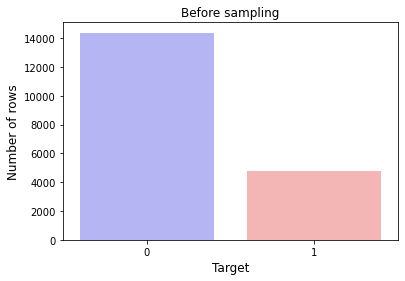

In [43]:
plt.figure(figsize =(6,4))
sns.barplot(Y.value_counts().index.astype(int),Y.value_counts().values,palette='bwr')
plt.ylabel('Number of rows', fontsize=12)
plt.xlabel('Target', fontsize=12)
plt.title('Before sampling')
plt.show()

In [44]:
oversample = SMOTE()
smote = SMOTE(random_state=0)
X_smote, y_smote = smote.fit_resample(X,Y)

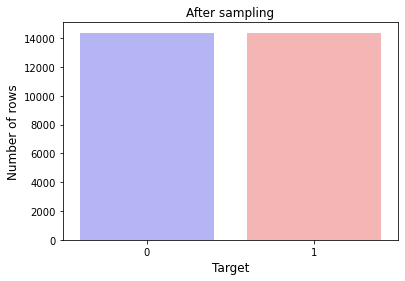

In [45]:
plt.figure(figsize=(6, 4))
sns.barplot(y_smote.value_counts().index.astype(int),
            y_smote.value_counts().values, palette='bwr')
plt.ylabel('Number of rows', fontsize=12)
plt.xlabel('Target', fontsize=12)
plt.title('After sampling')
plt.show()

In [46]:
X_train, X_test, y_train, y_test = train_test_split(X_smote,y_smote,test_size=0.3,random_state=42)

### Decision Tree Classifier

              precision    recall  f1-score   support

         0.0       0.75      0.74      0.74      4325
         1.0       0.74      0.76      0.75      4304

    accuracy                           0.75      8629
   macro avg       0.75      0.75      0.75      8629
weighted avg       0.75      0.75      0.75      8629



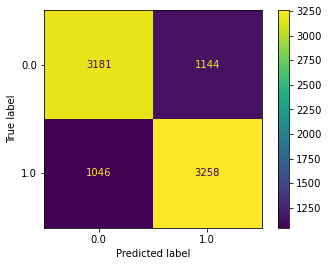

In [47]:
clf = DecisionTreeClassifier()
clf = clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
print(metrics.classification_report(y_test, y_pred, zero_division=0))
metrics.confusion_matrix(y_test,y_pred)
plot_confusion_matrix(clf, X_test, y_test)  
plt.show()

### Decision Tree Classifier With Hyperparameter Tuning


              precision    recall  f1-score   support

         0.0       0.77      0.79      0.78      4325
         1.0       0.78      0.77      0.78      4304

    accuracy                           0.78      8629
   macro avg       0.78      0.78      0.78      8629
weighted avg       0.78      0.78      0.78      8629

[[3419  906]
 [ 997 3307]]


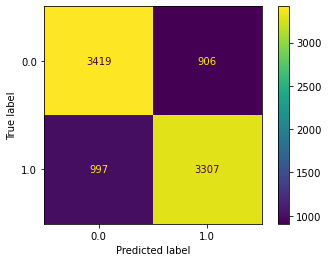

In [60]:
sc = StandardScaler()

X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

# Tuned Decision Tree Parameters: {'class_weight': None, 'criterion': 'gini', 'max_depth': 10, 'min_impurity_decrease': 0, 'min_samples_split': 2}
# param_list = {'criterion': ['gini', 'entropy'],
#                   'max_depth': [10, None],
#                   'class_weight': ['balanced', None],
#                   'min_samples_split': [2],
#                   'min_impurity_decrease': [*range(0, 20, 1)]
                  
tree = DecisionTreeClassifier(class_weight=None,criterion='gini', max_depth=10,min_impurity_decrease=0,min_samples_split=2)

# tree_cv = GridSearchCV(tree, param_list, cv=5)

tree.fit(X_train, y_train)

y_pred = tree.predict(X_test)

# print("Tuned Decision Tree Parameters: {}".format(tree.best_params_))
print()
print(metrics.classification_report(y_test, y_pred, zero_division=0))

print(metrics.confusion_matrix(y_test, y_pred))

plot_confusion_matrix(tree,X_test,y_test)
plt.show()

## Random Forest Classifier

              precision    recall  f1-score   support

         0.0       0.81      0.82      0.81      4325
         1.0       0.81      0.80      0.81      4304

    accuracy                           0.81      8629
   macro avg       0.81      0.81      0.81      8629
weighted avg       0.81      0.81      0.81      8629

[[3534  791]
 [ 852 3452]]


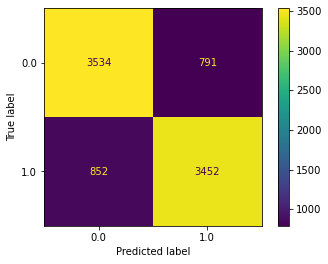

In [57]:
rft = RandomForestClassifier()
rft = rft.fit(X_train,y_train)
y_pred = rft.predict(X_test)
print(metrics.classification_report(y_test, y_pred, zero_division=0))
print(metrics.confusion_matrix(y_test,y_pred))

plot_confusion_matrix(rft, X_test, y_test)  
plt.show()